
# India vs England Test Series — Analysis
**Goal:** Use ball-by-ball or summary score data to compute insightful metrics for the 5-Test India vs England series (June–Aug 2025).


1. **Load data (you write this):**
   - Read CSV into a DataFrame
   - Check shape, preview the head, verify column dtypes
   - Handle missing values where appropriate


In [93]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt
%matplotlib inline


In [94]:
#Checking the shape
data = pd.read_csv("ind_eng_2025_tests_balls.csv")
data.shape

(11301, 24)

In [95]:
#Reviewing the first 5 rows
data.head(5)

,match_id,season,date_list,venue,city,teams,innings,batting_team,over,ball_label,...,runs_extras,runs_total,extra_byes,extra_legbyes,extra_wides,extra_noballs,extra_penalty,wicket_kind,wicket_player_out,wicket_fielders
0,1,2025,"2025-06-20,2025-06-21,2025-06-22,2025-06-23,20...","Headingley, Leeds",Leeds,"India,England",1,India,0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,2025,"2025-06-20,2025-06-21,2025-06-22,2025-06-23,20...","Headingley, Leeds",Leeds,"India,England",1,India,0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,2025,"2025-06-20,2025-06-21,2025-06-22,2025-06-23,20...","Headingley, Leeds",Leeds,"India,England",1,India,0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,1,2025,"2025-06-20,2025-06-21,2025-06-22,2025-06-23,20...","Headingley, Leeds",Leeds,"India,England",1,India,0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,2025,"2025-06-20,2025-06-21,2025-06-22,2025-06-23,20...","Headingley, Leeds",Leeds,"India,England",1,India,0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,NaN



## 1) Data Sanity Checks (write your code)

In [96]:
# Confirm there are exactly 5 matches (by counting `match_id`).
data['match_id'].drop_duplicates().reset_index()['match_id']

0    1
1    2
2    3
3    4
4    5
Name: match_id, dtype: int64

In [97]:
#Confirm innings numbering (1–4 per match, or fewer if innings didn’t happen).
data.groupby(by=['match_id'],as_index=False)['innings'].nunique().rename(columns={'innings':'number of innings'})

,match_id,number of innings
0,1,4
1,2,4
2,3,4
3,4,3
4,5,4


In [98]:
#Verify that `runs_total = runs_batter + runs_extras` for each delivery.
#all(data['runs_total'] == (data['runs_batter'] + data['runs_extras']))

is_clean = (data['runs_total'].eq(data['runs_batter']+data['runs_extras'])).all()
print(is_clean)


True


In [99]:
#Check that extras columns sum to `runs_extras` (byes + legbyes + wides + noballs + penalty).

is_extras_clean = (data['runs_extras'].eq(data['extra_byes']+data['extra_legbyes']+data['extra_wides']+data['extra_noballs']+data['extra_penalty'])).all()
print(is_extras_clean)

True


In [117]:
#Create a derived **ball number** per innings if helpful (e.g., cumulative ball index).
data['event_in_over'] = data.groupby(by=['match_id','innings','over']).cumcount()+1
data['event_in_innings'] = data.groupby(by=['match_id','innings']).cumcount()+1
data = data.assign(is_legal =  lambda x: ~((x['extra_wides'].fillna(0)>0)| (x['extra_noballs'].fillna(0)>0)))
data['legal_event_in_over'] = data.groupby(by=['match_id','innings','over'])['is_legal'].cumsum()
data['legal_event_in_innings'] = data.groupby(by=['match_id','innings'])['is_legal'].cumsum()



## 2) Core Metrics (Top 8)

Below are eight interesting metrics. For each metric, **write your own code** to compute, sort, and present results.

### 2.1 Top Run Scorers
- **Definition:** Total runs by batter across the series.
- **Hints:** Group by `batter`, sum `runs_batter`, sort descending. Join with dismissals if you want averages later.

In [123]:
data.groupby(by='batter')['runs_batter'].sum().sort_values(ascending=False)

batter
Shubman Gill           754
JE Root                537
KL Rahul               532
RA Jadeja              516
HC Brook               481
RR Pant                479
BM Duckett             462
JL Smith               434
YBK Jaiswal            411
OJ Pope                306
BA Stokes              304
Z Crawley              290
Washington Sundar      284
KK Nair                205
BA Carse               164
B Sai Sudharsan        140
Akash Deep              80
CR Woakes               64
Dhruv Jurel             53
SN Thakur               46
Nithish Kumar Reddy     45
AAP Atkinson            28
LA Dawson               26
Mohammed Siraj          20
Shoaib Bashir           16
JC Tongue               13
JC Archer               11
JG Bethell              11
J Overton                9
JJ Bumrah                9
M Prasidh Krishna        6
A Kamboj                 0
Name: runs_batter, dtype: int64

### 2.2 Highest Batting Strike Rate (Min. 100 balls faced)
- **Definition:** `(sum of runs_batter / balls_faced) * 100`.
- **Hints:** Balls faced per batter = count of deliveries faced (excluding wides). Apply a minimum threshold (>=100 balls).

In [ ]:
batter_data = data.groupby(by='batter').agg(
    runs_scored = ('runs_batter','sum'),
    balls_faced=('is_legal','sum')
)
batter_data['strike_rate'] = (batter_data['runs_scored'] / batter_data['balls_faced'])*100
batter_data.sort_values(by='strike_rate',ascending=False)

,runs_scored,balls_faced,strike_rate
batter,,,
BM Duckett,462,552,83.695652
HC Brook,481,582,82.646048
JL Smith,434,542,80.073801
RR Pant,479,612,78.267974
BA Carse,164,214,76.635514
YBK Jaiswal,411,592,69.425676
Shubman Gill,754,1139,66.198420
Z Crawley,290,460,63.043478
Dhruv Jurel,53,85,62.352941


### 2.3 Conversion Rate (50 → 100)
- **Definition:** `#100s / #50s` per batter.
- **Hints:** Aggregate runs per **completed innings** (not per delivery). You can construct innings totals by grouping by (`match_id`, `innings`, `batter`) and summing `runs_batter`. Then count 50s and 100s per player.

In [185]:

runs_by_innings = data.groupby(by=['match_id','innings','batter']).agg(runs_scored=('runs_batter','sum')).reset_index()
runs_by_innings['fifty_plus'] = np.where((runs_by_innings['runs_scored'] >= 50),1,0)
runs_by_innings['hundred_plus'] = np.where((runs_by_innings['runs_scored'] >= 100),1,0)
runs_by_series = runs_by_innings.groupby(by='batter').agg(fifties=('fifty_plus','sum'),hundreds=('hundred_plus','sum'))
runs_by_series['conversion_rate'] = (runs_by_series['hundreds'] / runs_by_series['fifties'])*100
runs_by_series.sort_values(by=['hundreds','fifties'],ascending=False)

,fifties,hundreds,conversion_rate
batter,,,
Shubman Gill,4,4,100.000000
JE Root,4,3,75.000000
RR Pant,5,2,40.000000
HC Brook,4,2,50.000000
KL Rahul,4,2,50.000000
YBK Jaiswal,4,2,50.000000
RA Jadeja,6,1,16.666667
BM Duckett,4,1,25.000000
JL Smith,3,1,33.333333


### 2.4 Leading Wicket Takers
- **Definition:** Total wickets taken by bowler.
- **Hints:** Count deliveries where `wicket_kind` is not null and credit the wicket to `bowler`. (Decide how to treat run-outs separately.)

In [240]:
bowler_data = data

bowler_data['is_bowler_wicket'] = np.where(bowler_data['wicket_kind'].isin(['caught','bowled','lbw','caught and bowled']),1,0)
bowler_data['dot_ball'] = np.where(bowler_data['runs_total']>0,0,1)
bowler_data = bowler_data.groupby(by='bowler').agg(total_wickets = ('is_bowler_wicket','sum'),runs_conceded=('runs_total','sum'),total_balls=('match_id','count'),dot_balls=('dot_ball','sum')).sort_values(by='total_wickets',ascending=False)

bowler_data.head()

,total_wickets,runs_conceded,total_balls,dot_balls
bowler,,,,
Mohammed Siraj,23,794,1122,734
JC Tongue,19,578,777,506
BA Stokes,17,448,857,599
JJ Bumrah,14,402,728,524
M Prasidh Krishna,14,533,638,389


### 2.5 Best Bowling Average (Min. 5 wickets)
- **Definition:** `runs_conceded / wickets` for each bowler.
- **Hints:** Sum `runs_total` conceded per bowler; divide by wickets. Filter to bowlers with >=5 wickets. (You may wish to exclude penalty runs and certain extras by choice.)

In [204]:
top_bowlers = bowler_data[bowler_data['total_wickets']>5].copy()
top_bowlers['bowling_average'] = top_bowlers['runs_conceded'] / bowler_data['total_wickets']
top_bowlers

,total_wickets,runs_conceded,bowling_average
bowler,,,
Mohammed Siraj,23,794,34.521739
JC Tongue,19,578,30.421053
BA Stokes,17,448,26.352941
JJ Bumrah,14,402,28.714286
M Prasidh Krishna,14,533,38.071429
Akash Deep,13,495,38.076923
CR Woakes,11,583,53.000000
BA Carse,9,567,63.000000
Shoaib Bashir,9,553,61.444444


### 2.6 Highest Dot Ball Percentage
- **Definition:** `(dot balls / total balls) * 100` per bowler.
- **Hints:** Dot ball = `runs_total == 0` (consider whether wides/no-balls count as balls for your definition). Compute dot count and total legal deliveries bowled.

In [208]:
bowler_data['dot_ball_percentage'] = (bowler_data['dot_balls']/bowler_data['total_balls'])*100
bowler_data

,total_wickets,runs_conceded,total_balls,dot_balls,dot_ball_percentage
bowler,,,,,
Mohammed Siraj,23,794,1122,388,34.581105
JC Tongue,19,578,777,271,34.877735
BA Stokes,17,448,857,258,30.105018
JJ Bumrah,14,402,728,204,28.021978
M Prasidh Krishna,14,533,638,249,39.028213
Akash Deep,13,495,669,224,33.482810
CR Woakes,11,583,1095,278,25.388128
BA Carse,9,567,951,289,30.389064
Shoaib Bashir,9,553,846,309,36.524823


### 2.7 Most Valuable Partnership (Highest Runs for a Wicket)
- **Definition:** Max partnership runs for each wicket number across the series.
- **Hints:** Build partnerships by innings. Reset when a wicket falls. Sum `runs_total` between wickets. Track pair of batters and wicket number.

In [218]:
partner_data = data
partner_data['batting_combo'] = partner_data.apply(lambda row: tuple(sorted([row['batter'],row['non_striker']])),axis=1)
partner_data.groupby(by=['match_id','innings','batting_combo']).agg(total_runs=('runs_total','sum')).sort_values(by=['match_id','innings','total_runs'],ascending=[True,True,False])

total_runs
match_id innings batting_combo                          
1        1       (RR Pant, Shubman Gill)             209
                 (Shubman Gill, YBK Jaiswal)         129
                 (KL Rahul, YBK Jaiswal)              91
                 (KK Nair, RR Pant)                   17
                 (Mohammed Siraj, RA Jadeja)          11
...                                                  ...
5        4       (AAP Atkinson, CR Woakes)            10
                 (J Overton, JL Smith)                10
                 (AAP Atkinson, J Overton)             7
                 (JE Root, JL Smith)                   5
                 (AAP Atkinson, JC Tongue)             3

[179 rows x 1 columns]

### 2.8 **Extras Breakdown by Team:** Sum `extra_byes`, `extra_legbyes`, `extra_wides`, `extra_noballs`, `extra_penalty` by `batting_team` and by `match_id`.

In [221]:
team_data = data
team_data['extras'] = team_data['extra_byes'] +team_data['extra_legbyes'] + team_data['extra_wides'] + team_data['extra_noballs'] + team_data['extra_penalty']
team_data = team_data.groupby(by=['match_id','batting_team']).agg(total_extras=('extras','sum'))
team_data

total_extras
match_id batting_team              
1        England                 55
         India                   49
2        England                 32
         India                   32
3        England                 63
         India                   30
4        England                 38
         India                   54
5        England                 34
         India                   64


## 3) Visualizations 

- **Bar charts** for top 10 batters

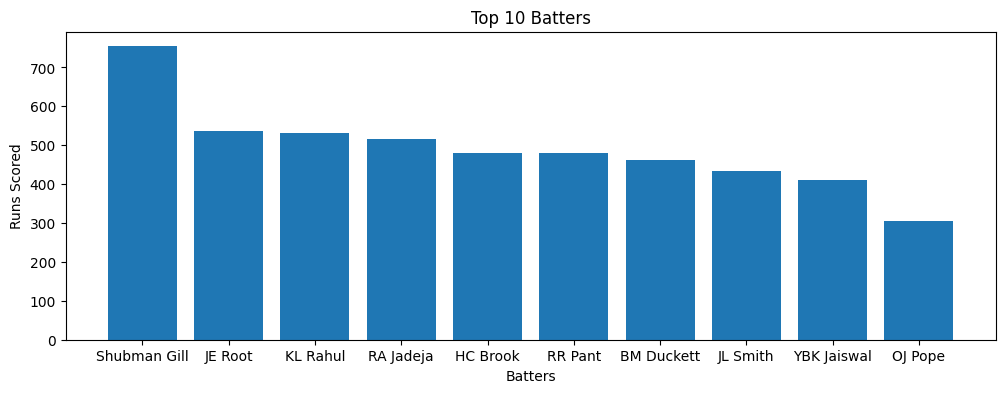

In [ ]:
top_10_batters = batter_data.sort_values(by='runs_scored',ascending=False).head(10).reset_index()

pt.figure(figsize=(12,4))
pt.bar(top_10_batters['batter'],top_10_batters['runs_scored'])
pt.title('Top 10 Batters')
pt.xlabel('Batters')
pt.ylabel('Runs Scored')
pt.grid(visible=False)
pt.show()


- **Bar charts** for top 10 bowlers

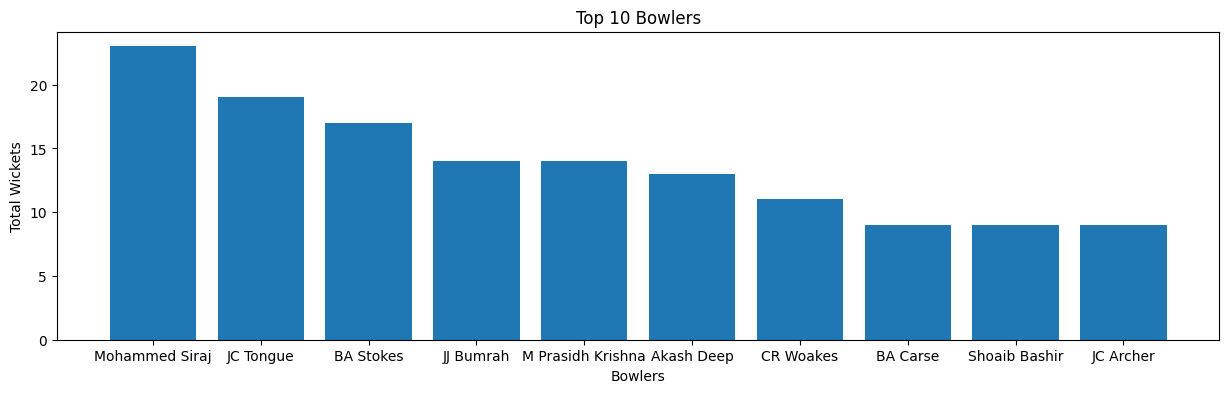

In [239]:
top_10_bowlers= bowler_data.sort_values(by='total_wickets',ascending=False).head(10).reset_index()

pt.figure(figsize=(15,4))
pt.bar(top_10_bowlers['bowler'],top_10_bowlers['total_wickets'])
pt.title('Top 10 Bowlers')
pt.xlabel('Bowlers')
pt.ylabel('Total Wickets')
pt.grid(visible=False)
pt.show()